In [1]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

#from string import ascii_letters

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [3]:
df =pd.read_pickle('../pickle_pd/pd_top_25.pkl')
features = ['lep_pt_2','lep_pt_1','jet_n','lep_E_1','jet_pt_0','lep_eta_0','jet_pt_1','lep_pt_0','lep_E_2','lep_eta_1','lep_phi_1','lep_phi_0',
            'lep_ptcone30_1','lep_ptcone30_0','jet_eta_0','jet_m','lep_E_0','jet_eta_1','jet_pt_2','lep_pt_3','jet_E_0','lep_charge_1','lep_charge_0','lep_E_3']

In [4]:
y = df.pop('label')

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = tf.keras.utils.to_categorical(y_encoded)

In [6]:
len(list(df))

24

In [7]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], y_one_hot, test_size=0.2, random_state=42)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

In [8]:
space={#'dimension': hp.uniform("dimension", 64, 256),
        'learning_rate': hp.uniform ('learning_rate', 0.0005,0.005),
        'beta_1' : hp.uniform('beta_1', 0.5,0.99),
        'beta_2' : hp.uniform('beta_2', 0.8,0.9999),
        'epsilon' : hp.uniform('epsilon', 1e-08,1e-06),
        'ema_momentum' : hp.uniform('ema_momentum', 0.8, 0.999),
        'dropout' : hp.uniform('dropout', 0,0.5)
    }

In [9]:
def objective(space):
    optimizer = Adam(learning_rate=space['learning_rate'], beta_1=space['beta_1'], beta_2=space['beta_2'], epsilon=space['epsilon'], ema_momentum=space['ema_momentum'])
                
    model = Sequential([
            Dense(128, activation='relu', input_dim=24),
                Dropout(space['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    #model.fit(X_train, y_train,
    #        eval_set=evaluation, #eval_metric="auc",
    #        early_stopping_rounds=10,verbose=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    fit_results = model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=65,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )
    

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                            | 0/50 [00:00<?, ?trial/s, best loss=?]

1628/1628 [==============================] - 0s 213us/step             

SCORE:                                                                  
0.7013884887941465                                                      
  2%| | 1/50 [00:56<46:23, 56.81s/trial, best loss: -0.7013884887941465]

In [48]:
best_hyperparams

{'beta_1': 0.9593236183127343,
 'beta_2': 0.8958117134241359,
 'dropout': 0.7226298060232322,
 'ema_momentum': 0.9911711558419362,
 'epsilon': 7.439109990333436e-07,
 'learning_rate': 0.0016650854163453006}

In [95]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=24),
                Dropout(best_hyperparams['dropout']),
            Dense(64, activation='relu'),
                Dropout(best_hyperparams['dropout']),
            Dense(32, activation='relu'),
                Dropout(best_hyperparams['dropout']),
            Dense(3, activation='softmax')
            ])     

optimizer = Adam(learning_rate=best_hyperparams['learning_rate'], beta_1=best_hyperparams['beta_1'], beta_2=best_hyperparams['beta_2'], epsilon=best_hyperparams['epsilon'], ema_momentum=best_hyperparams['ema_momentum'])
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=65,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )

y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 3s 2ms/step


In [102]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

(0.0, 10.0)

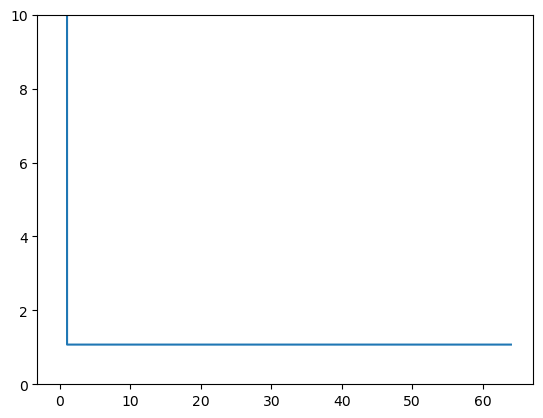

In [104]:
plt.plot(history.history['loss'])
plt.ylim(0,10)

In [96]:
y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 7s 4ms/step


In [97]:
y_pred.shape

(52071, 3)

In [98]:
y_pred[0]

array([0.38784254, 0.38291648, 0.22924091], dtype=float32)

In [99]:
y_pred = np.argmax(y_pred,axis=1)

In [100]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
y_test = np.argmax(y_test,axis=1)

In [82]:
y_test

array([2, 0, 0, ..., 1, 0, 0])

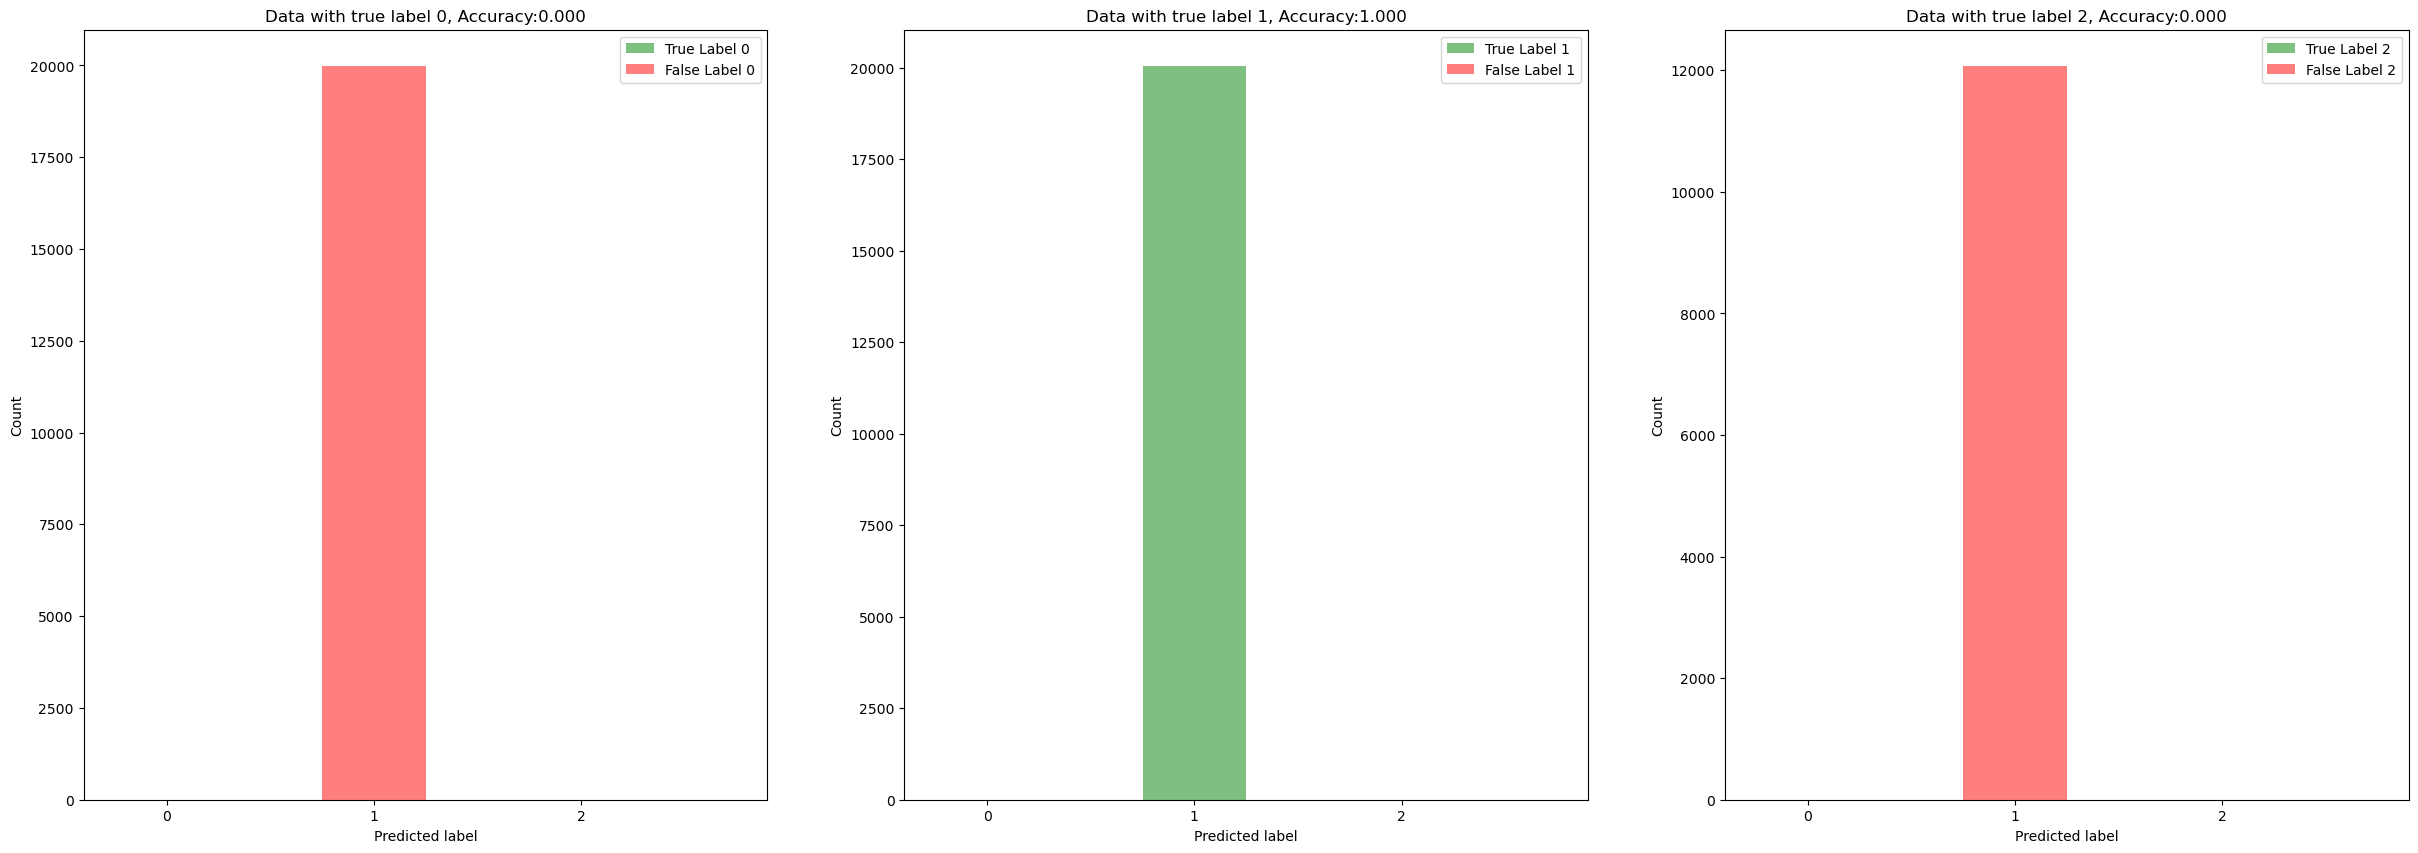

In [83]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_test[y_test==label]
    pred_label = y_pred[y_test==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))